In [145]:
import numpy as np
import pandas as pd
import cv2
import glob
import sys, os, multiprocessing
from PIL import Image
from shutil import copyfile

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
file_paths = glob.glob("../data/imgs/*.jpg")

In [3]:
file_paths[1]

'../data/imgs/185146_76.jpg'

In [146]:
def process_image(path):
    '''
    open an image at path:
    figure out:
    h - height
    w - width
    size - size of file
    ratio - amount of Bytes per pixel
    '''
    img = cv2.imread(path)
    
    print(path + "\r", end="", flush=True)
    
    if img is not None:
        item_dict = {}
        
        h, w = img.shape[0], img.shape[1]
        
        if h > 50 and w > 50:
        
            aspect_ratio = w / (h * 1.0)

            pixels = h * w

            st = os.stat(path)
            file_size = st.st_size

            b, g, r = cv2.split(img)         # get b,g,r

            all_r_mean = 176.00384963451177
            all_g_mean = 166.20842509882658
            all_b_mean = 158.0920543886322

            r_mean = np.mean(r)
            g_mean = np.mean(g)
            b_mean = np.mean(b)

            item_dict['h'] = h
            item_dict['w'] = w
            item_dict['aspect_ratio'] = aspect_ratio
            item_dict['pixels'] = pixels
            item_dict['file_size'] = file_size
            item_dict['r_mean'] = r_mean
            item_dict['g_mean'] = g_mean
            item_dict['b_mean'] = b_mean
            item_dict["pix_pb"] = pixels / (file_size * 1.0)
            item_dict["path"] = path
            item_dict["r_accum_err"] = np.sum((r - all_r_mean)**2)/pixels
            item_dict["g_accum_err"] = np.sum((g - all_g_mean)**2)/pixels
            item_dict["b_accum_err"] = np.sum((b - all_b_mean)**2)/pixels

    #         temp_img = cv2.merge([r, g, b])    # switch it to rgb
            new_path = "../data/clean_raw/" + path.split("/")[-1]
    
#             write_img = Image.open(path)
    
            try:
                copyfile(path, new_path)
            except:
                print('Warning: Failed to save image %s' % filename)
    
            return item_dict
        else:
            return None
        
    else:
        return None

In [147]:
# data = []
# junk = []

# start = time.time()

# for idx, path in enumerate(file_paths):
#     # 18.35s
#     # 16.1s if not printing every read
# #     if idx > 1901:
# #         break
    
#     result = process_image(path)
    
#     if idx % 100 == 0:
#         elapsed = time.time() - start
#         print("time: {:4.2f}s   processing {:}/{:}\r".format(elapsed, idx, len(file_paths)), end="", flush=True)
    
#     if result is not None:
#         data.append(result)


In [5]:
data = []

p = multiprocessing.Pool(processes=100)
data = p.map(process_image, [path for path in file_paths])
p.close()

print(len(data))

190411a/imgs/155702_125.jpg


In [237]:
clean_data = [row for row in data if row is not None]

In [238]:
print(len(clean_data))

clean_data[0]

190396


{'aspect_ratio': 1.0,
 'b_accum_err': 3001.4325581814905,
 'b_mean': 147.0363484375,
 'file_size': 128286,
 'g_accum_err': 3322.7534465755766,
 'g_mean': 145.8245546875,
 'h': 800,
 'path': '../data/imgs/5766_86.jpg',
 'pix_pb': 4.988853031507725,
 'pixels': 640000,
 'r_accum_err': 4585.750255011382,
 'r_mean': 140.5760359375,
 'w': 800}

In [239]:
df = pd.DataFrame(clean_data, columns=["path", "h", "w", "pixels", "aspect_ratio", "file_size", "pix_pb", "r_mean", "g_mean", "b_mean", "r_accum_err", "g_accum_err", "b_accum_err"])

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190396 entries, 0 to 190395
Data columns (total 13 columns):
path            190396 non-null object
h               190396 non-null int64
w               190396 non-null int64
pixels          190396 non-null int64
aspect_ratio    190396 non-null float64
file_size       190396 non-null int64
pix_pb          190396 non-null float64
r_mean          190396 non-null float64
g_mean          190396 non-null float64
b_mean          190396 non-null float64
r_accum_err     190396 non-null float64
g_accum_err     190396 non-null float64
b_accum_err     190396 non-null float64
dtypes: float64(8), int64(4), object(1)
memory usage: 18.9+ MB


In [241]:
df.head()

,path,h,w,pixels,aspect_ratio,file_size,pix_pb,r_mean,g_mean,b_mean,r_accum_err,g_accum_err,b_accum_err
0,../data/imgs/5766_86.jpg,800,800,640000,1.000000,128286,4.988853,140.576036,145.824555,147.036348,4585.750255,3322.753447,3001.432558
1,../data/imgs/185146_76.jpg,800,800,640000,1.000000,117650,5.439864,182.197589,160.468755,163.731077,2744.201237,2468.796831,2708.509562
2,../data/imgs/107259_53.jpg,803,1200,963600,1.494396,82157,11.728763,157.738790,163.155018,157.571339,1982.503450,1808.718875,1687.411072
3,../data/imgs/28210_68.jpg,1000,971,971000,0.971000,143748,6.754877,172.242527,189.619725,207.394022,6413.232191,4704.347341,7332.541797
4,../data/imgs/45715_105.jpg,800,800,640000,1.000000,155172,4.124455,135.337081,127.190166,76.466955,4039.534133,5043.600309,10217.445737


In [242]:
df.loc[:, "r_accum_err"] /= df.loc[:, "pixels"]
df.loc[:, "g_accum_err"] /= df.loc[:, "pixels"]
df.loc[:, "b_accum_err"] /= df.loc[:, "pixels"]

In [243]:
df.head()

,path,h,w,pixels,aspect_ratio,file_size,pix_pb,r_mean,g_mean,b_mean,r_accum_err,g_accum_err,b_accum_err
0,../data/imgs/5766_86.jpg,800,800,640000,1.000000,128286,4.988853,140.576036,145.824555,147.036348,0.007165,0.005192,0.004690
1,../data/imgs/185146_76.jpg,800,800,640000,1.000000,117650,5.439864,182.197589,160.468755,163.731077,0.004288,0.003857,0.004232
2,../data/imgs/107259_53.jpg,803,1200,963600,1.494396,82157,11.728763,157.738790,163.155018,157.571339,0.002057,0.001877,0.001751
3,../data/imgs/28210_68.jpg,1000,971,971000,0.971000,143748,6.754877,172.242527,189.619725,207.394022,0.006605,0.004845,0.007552
4,../data/imgs/45715_105.jpg,800,800,640000,1.000000,155172,4.124455,135.337081,127.190166,76.466955,0.006312,0.007881,0.015965


In [244]:
r_std = np.sqrt(np.sum(df.loc[:, "r_accum_err"].values))
g_std = np.sqrt(np.sum(df.loc[:, "g_accum_err"].values))
b_std = np.sqrt(np.sum(df.loc[:, "b_accum_err"].values))

print("red std:", r_std)
print("blue std:", g_std)
print("green std:", b_std)

red std: 53.940064598213006
blue std: 56.605030104903534
green std: 59.870462351866806


(0, 62.47748176410204)

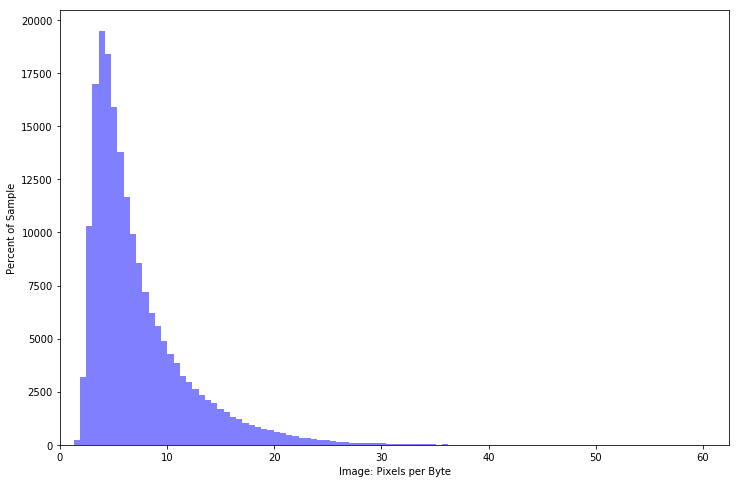

In [245]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(df.loc[:, "pix_pb"].values, bins=100, alpha=0.5, normed=False, color="blue")
ax.set_xlabel("Image: Pixels per Byte")
ax.set_ylabel("Percent of Sample")
ax.set_xlim(0)

In [246]:
_imgs = df[df.loc[:, "pix_pb"] < 1]

In [247]:
# df.to_csv("../data/image_file_features.csv", sep="\t")

In [248]:
# old means
# all_r_mean: 176.00384963451177
# all_g_mean: 166.20842509882658
# all_b_mean: 158.0920543886322

all_r_mean = df.loc[:, "r_mean"].values.mean()
print("all_r_mean:", all_r_mean)

all_g_mean = df.loc[:, "g_mean"].values.mean()
print("all_g_mean:", all_g_mean)

all_b_mean = df.loc[:, "b_mean"].values.mean()
print("all_b_mean:", all_b_mean)

all_r_mean: 176.02548734542899
all_g_mean: 166.17418689474772
all_b_mean: 158.12139747811295


In [249]:
df.loc[:, "labels"] = df.loc[:, "path"].apply(lambda x: int(x.split("_")[-1].split(".")[0]))

df.loc[:, "path"] = df.loc[:, "path"].apply(lambda x: "../data/stage3_imgs/" + x.split("/")[-1])

In [250]:
df.keys()

Index(['path', 'h', 'w', 'pixels', 'aspect_ratio', 'file_size', 'pix_pb',
       'r_mean', 'g_mean', 'b_mean', 'r_accum_err', 'g_accum_err',
       'b_accum_err', 'labels'],
      dtype='object')

In [251]:
df.head()

,path,h,w,pixels,aspect_ratio,file_size,pix_pb,r_mean,g_mean,b_mean,r_accum_err,g_accum_err,b_accum_err,labels
0,../data/stage3_imgs/5766_86.jpg,800,800,640000,1.000000,128286,4.988853,140.576036,145.824555,147.036348,0.007165,0.005192,0.004690,86
1,../data/stage3_imgs/185146_76.jpg,800,800,640000,1.000000,117650,5.439864,182.197589,160.468755,163.731077,0.004288,0.003857,0.004232,76
2,../data/stage3_imgs/107259_53.jpg,803,1200,963600,1.494396,82157,11.728763,157.738790,163.155018,157.571339,0.002057,0.001877,0.001751,53
3,../data/stage3_imgs/28210_68.jpg,1000,971,971000,0.971000,143748,6.754877,172.242527,189.619725,207.394022,0.006605,0.004845,0.007552,68
4,../data/stage3_imgs/45715_105.jpg,800,800,640000,1.000000,155172,4.124455,135.337081,127.190166,76.466955,0.006312,0.007881,0.015965,105


In [252]:
def dictofy(values):
    '''
    take a numpy array and convert it to a dictionary
    
    return dictionary of row of data
    '''
    these_keys = ['path', 'h', 'w', 'pixels', 'aspect_ratio', 'file_size', 'pix_pb',
             'r_mean', 'g_mean', 'b_mean', 'r_accum_err', 'g_accum_err',
             'b_accum_err']
    t_data = {}
    
    for idx, this_key in enumerate(these_keys): 
        t_data[this_key] = values[idx]
        
    return t_data
        
#     print(data)

In [253]:
dictofy(data_vault[0])

{'aspect_ratio': 1.0,
 'b_accum_err': 0.004689738372158579,
 'b_mean': 147.0363484375,
 'file_size': 128286,
 'g_accum_err': 0.005191802260274338,
 'g_mean': 145.8245546875,
 'h': 800,
 'path': '../data/imgs/5766_86.jpg',
 'pix_pb': 4.988853031507725,
 'pixels': 640000,
 'r_accum_err': 0.0071652347734552846,
 'r_mean': 140.5760359375,
 'w': 800}

In [254]:
labels = df.loc[:, "labels"].values
data_core = df.drop("labels", axis=1)
data_vault = data_core.values

print("ok")
# data_vault.loc[:, "data"] = df.loc[:, ['h', 'w', 'pixels']]
#                                                      'aspect_ratio', 'file_size',
#                                                      'pix_pb', 'r_mean', 'g_mean',
#                                                      'b_mean', 'r_accum_err',
#                                                      'g_accum_err', 'b_accum_err',
#                                                      'labels']]
# print(data_vault[:5])

# data_core.head()
labels = labels.reshape(-1, 1)
print(len(data_core), len(labels))
print(data_core.shape, labels.shape)

ok
190396 190396
(190396, 13) (190396, 1)


In [255]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)

initial_data_dict = {}

fold = 0
for train_index, test_index in skf.split(data_vault, labels):
    fold += 1
    if fold > 3:
        break
        
    initial_data_dict["X_train_{:}".format(fold)] = data_vault[train_index]
    initial_data_dict["X_test_{:}".format(fold)] = data_vault[test_index]
    
    initial_data_dict["y_train_{:}".format(fold)] = list(labels[train_index])
    initial_data_dict["y_test_{:}".format(fold)] = list(labels[test_index])

In [256]:
initial_data_dict.keys()

dict_keys(['X_train_1', 'X_test_1', 'y_train_1', 'y_test_1', 'X_train_2', 'X_test_2', 'y_train_2', 'y_test_2', 'X_train_3', 'X_test_3', 'y_train_3', 'y_test_3'])

In [257]:
initial_data_dict["X_train_1"]

array([['../data/stage3_imgs/70691_65.jpg', 800, 800, ...,
        0.01741619515134654, 0.017224911024578352, 0.017017211562164382],
       ['../data/stage3_imgs/44175_48.jpg', 541, 590, ...,
        0.006081587137431892, 0.0060023336024812544,
        0.006234955936934886],
       ['../data/stage3_imgs/70801_65.jpg', 800, 800, ...,
        0.01397158523195341, 0.015094079208649677, 0.01610358172970077],
       ...,
       ['../data/stage3_imgs/91908_2.jpg', 800, 800, ...,
        0.011451279640070491, 0.012481209469475231, 0.013602589748566865],
       ['../data/stage3_imgs/57772_78.jpg', 640, 640, ...,
        0.01954047339293043, 0.020193265082400776, 0.021333275301984332],
       ['../data/stage3_imgs/77151_121.jpg', 363, 363, ...,
        0.013992301608251061, 0.036537359271515094, 0.04618213670272627]],
      dtype=object)

In [258]:
final_data_dict = initial_data_dict.copy()

In [259]:
final_data_dict.keys()

dict_keys(['X_train_1', 'X_test_1', 'y_train_1', 'y_test_1', 'X_train_2', 'X_test_2', 'y_train_2', 'y_test_2', 'X_train_3', 'X_test_3', 'y_train_3', 'y_test_3'])

In [260]:
final_data_dict = initial_data_dict.copy()

for _key in final_data_dict.keys():
    if "X" in _key:
        temp_list = []
        print(_key)

        for idx in range(len(final_data_dict[_key])):
            temp_list.append(dictofy(final_data_dict[_key][idx]))

        final_data_dict[_key] = temp_list
        
    elif "y" in _key:
        final_data_dict[_key] = [int(item[0]) for item in final_data_dict[_key]]

X_train_1
X_test_1
X_train_2
X_test_2
X_train_3
X_test_3


In [261]:
for key in final_data_dict.keys():
    print(key)
    print(final_data_dict[key][:5])

X_train_1
[{'path': '../data/stage3_imgs/70691_65.jpg', 'h': 800, 'w': 800, 'pixels': 640000, 'aspect_ratio': 1.0, 'file_size': 94648, 'pix_pb': 6.761896712027724, 'r_mean': 166.2122390625, 'g_mean': 163.66376875, 'b_mean': 164.05480625, 'r_accum_err': 0.01741619515134654, 'g_accum_err': 0.017224911024578352, 'b_accum_err': 0.017017211562164382}, {'path': '../data/stage3_imgs/44175_48.jpg', 'h': 541, 'w': 590, 'pixels': 319190, 'aspect_ratio': 1.0905730129390019, 'file_size': 39796, 'pix_pb': 8.020655342245451, 'r_mean': 162.79629374353834, 'g_mean': 158.07347347974562, 'b_mean': 153.52589680127824, 'r_accum_err': 0.006081587137431892, 'g_accum_err': 0.0060023336024812544, 'b_accum_err': 0.006234955936934886}, {'path': '../data/stage3_imgs/70801_65.jpg', 'h': 800, 'w': 800, 'pixels': 640000, 'aspect_ratio': 1.0, 'file_size': 54903, 'pix_pb': 11.656922208258202, 'r_mean': 211.940196875, 'g_mean': 208.9548921875, 'b_mean': 207.8976234375, 'r_accum_err': 0.01397158523195341, 'g_accum_err'

In [262]:
import json

In [263]:
with open("../data/metadata_splits.json", "w") as outfile:
    json.dump(final_data_dict, outfile)